In [1]:
import pyart
import os
import numpy as np
from matplotlib import pyplot as plt
import netCDF4 
import warnings
from copy import deepcopy
from __future__ import print_function
warnings.filterwarnings("ignore")
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119 


In [2]:
# set debug flag
debug = True

In [3]:
filename = '/data/radar/oli_kazr/olikazrgeM1.a1.20160620.000001.nc'
radar = pyart.io.read(filename)
tsi_filename = '/data/radar/oli_kazr/olitsiskycoverM1.b1.20160620.000000.cdf'
tsi_dataset = netCDF4.Dataset(tsi_filename)
ceil_filename = '/data/radar/oli_kazr/oliceilM1.b1.20160620.000008.nc'
ceil_dataset = netCDF4.Dataset(ceil_filename)

In [40]:
# What is the greatest length of continious ceilometer cloud free?
#http://stackoverflow.com/questions/4494404/find-large-number-of-consecutive-values-fulfilling-condition-in-a-numpy-array

def contiguous_regions(condition):
    """Finds contiguous True regions of the boolean array "condition". Returns
    a 2D array where the first column is the start index of the region and the
    second column is the end index."""

    # Find the indicies of changes in "condition"
    d = np.diff(condition)
    idx, = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size] # Edit

    # Reshape the result into two columns
    idx.shape = (-1,2)
    return idx   



def sky_plot(radar, tsi_dataset, ceil_dataset, ofilename):
    ceil_dtimes = netCDF4.num2date(ceil_dataset.variables['time'][:], 
                               ceil_dataset.variables['time'].units)
    tsi_dtimes = netCDF4.num2date(tsi_dataset.variables['time'][:], 
                               tsi_dataset.variables['time'].units)
    my_display = pyart.graph.RadarDisplay(radar)
    my_fig = plt.figure(figsize = [15,10])
    ax1 = plt.subplot2grid((3,1), (0,0), rowspan = 2)
    ax2 = plt.subplot2grid((3,1), (2,0))

    my_display.plot_vpt('reflectivity', vmin=-64, 
                        vmax=20, time_axis_flag=True,
                       ax = ax1)

    ax1.plot(ceil_dtimes, 
            ceil_dataset.variables['first_cbh'][:]/1000.0,
            label='First cloud boundary')
    ax1.plot(ceil_dtimes,
            ceil_dataset.variables['second_cbh'][:]/1000.0,
            label='Second cloud boundary')
    ax1.plot(ceil_dtimes,
            ceil_dataset.variables['third_cbh'][:]/1000.0,
            label='Third cloud boundary')
    ax1.set_ylim([0,15])
    ax1.set_xlim([ceil_dtimes.min(), ceil_dtimes.max()])

    ax2.plot(tsi_dtimes, 
             tsi_dataset.variables['percent_opaque'][:],
             label='Percentage Opaque' )
    ax2.plot(tsi_dtimes, 
             tsi_dataset.variables['percent_thin'][:],
             label='Percentage Thin')


    pos1 = ax1.get_position() # get the original position 
    pos2 = ax2.get_position()
    pos3 = [pos2.x0 , pos2.y0 ,  pos1.width , pos2.height ] 
    ax2.set_position(pos3) # set a new position
    ax2.set_ylim([-1,101])
    ax2.set_xlim([ceil_dtimes.min(), ceil_dtimes.max()])
    ax2.set_ylabel('Percentage cloud cover from TSI')
    ax2.legend()
    ax1.legend()
    plt.savefig(ofilename)
    plt.close(my_fig)

def time_in_range(start, end, target):
    """
    Return true if target is in the range [start, end]
    Parameters
    ----------
    start: datetime
        Start of range to be tested
    end: datetime
        End of range to be tested
    target: datetime
        datetime to be tested
    Returns
    -------
    am_i: Boolean
        is the target between start and end 

    """
    if start <= end:
        am_i = start <= target <= end
    else:
        am_i = start <= x or x <= end
    return am_i

def find_nearest_index(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx


In [5]:
sky_plot(radar, tsi_dataset, ceil_dataset, '/Users/scollis/projects/ARM-Alaska/design_documents/uber.png')

In [26]:
#First some logical tests on the cloud covers

opaque_threshold = 20.0
thin_threshold = 20.0

is_sunny_op = tsi_dataset.variables['percent_opaque'][:] < opaque_threshold
is_sunny_tn = tsi_dataset.variables['percent_thin'][:] < thin_threshold
is_the_first_cb_masked = ceil_dataset.variables['first_cbh'][:].mask
#bulk all day tests

cloudy_all_day_opaque = not all(is_sunny_op)
cloudy_all_day_thin = not all(is_sunny_op)
no_clouds_in_ceil_all_day = all(is_the_first_cb_masked)
clouds_in_ceil_all_day = all(np.logical_not(is_the_first_cb_masked))

if debug:
    print('cloudy_all_day_opaque: ', cloudy_all_day_opaque)
    print('cloudy_all_day_thin: ', cloudy_all_day_thin)
    print('no_clouds_in_ceil_all_day: ', no_clouds_in_ceil_all_day)
    print('clouds_in_ceil_all_day: ', clouds_in_ceil_all_day)



cloudy_all_day_opaque:  True
cloudy_all_day_thin:  True
no_clouds_in_ceil_all_day:  False
clouds_in_ceil_all_day:  False


In [34]:
ceil_dtimes = netCDF4.num2date(ceil_dataset.variables['time'][:], 
                               ceil_dataset.variables['time'].units)
radar_dtimes = netCDF4.num2date(radar.time['data'], radar.time['units'])

In [27]:
ceil_cloud_free_regions = contiguous_regions(is_the_first_cb_masked)
ceil_cloud_free_len = \
    np.array([item[1] - item[0] for item in ceil_cloud_free_regions])

if ceil_cloud_free_regions[-1][1] == len(ceil_dtimes):
    ceil_cloud_free_regions[-1][1] = ceil_cloud_free_regions[-1][1] - 1
ceil_cloud_free_regions_time = \
    [[ceil_dtimes[item[0]], 
      ceil_dtimes[item[1]]] for item in ceil_cloud_free_regions]

ceil_cloud_free_len_time = \
 np.array([(item[1] - item[0]).total_seconds() for\
           item in ceil_cloud_free_regions_time])

In [28]:
print(ceil_cloud_free_len_time/60.0)
print(ceil_cloud_free_regions_time[ceil_cloud_free_len_time.argmax()])

[   0.26666667    1.86666667    0.26666667    0.28333333    0.26666667
    0.55          0.81666667    0.55          0.25          0.51666667
    0.8           0.55          0.26666667    0.53333333   14.11666667
    3.46666667    0.8           7.18333333    0.26666667  127.73333333
    7.48333333    0.8           8.8           0.8           0.28333333
    0.51666667    1.33333333    0.26666667    0.28333333    0.26666667
    0.53333333    1.08333333    1.05          0.51666667    0.78333333
    2.93333333    1.6           0.26666667    0.28333333    6.13333333
   18.4           0.53333333    0.26666667    0.26666667    0.28333333
    0.28333333    0.25          1.86666667   45.58333333   10.95      ]
[datetime.datetime(2016, 6, 20, 13, 11, 19), datetime.datetime(2016, 6, 20, 15, 19, 3)]


In [29]:
ceil_cloud_free_len_time.argmax()


19

Test Save

In [43]:
#copy the radar volume 
out_radar = deepcopy(radar)
ntimes, ngates = radar.fields['reflectivity']['data'].shape

In [44]:
#Pop fields
fields = out_radar.fields.keys()
for field in fields:
    del out_radar.fields[field]


In [45]:
# Redimension 
out_radar.nrays = 1
out_radar.time['data'] = out_radar.time['data'][0:1]
out_radar.elevation['data'] = out_radar.elevation['data'][0:1]
out_radar.azimuth['data'] = out_radar.azimuth['data'][0:1]
out_radar.instrument_parameters['prt']['data'] = out_radar.instrument_parameters['prt']['data'][0:1]
out_radar.instrument_parameters['nyquist_velocity']['data'] = out_radar.instrument_parameters['nyquist_velocity']['data'][0:1]
out_radar.instrument_parameters['pulse_width']['data'] = out_radar.instrument_parameters['pulse_width']['data'][0:1]
out_radar.instrument_parameters['n_samples']['data'] = out_radar.instrument_parameters['n_samples']['data'][0:1]
out_radar.instrument_parameters['unambiguous_range']['data'] = out_radar.instrument_parameters['unambiguous_range']['data'][0:1]


In [46]:
#metadata cleanup
cleanout = ['doi', 'process_version', 'comment', 'dod_version']
for item in cleanout:
    del out_radar.metadata[item]
out_radar.metadata['data_level'] = 'f1'
out_radar.metadata['process_version'] = '0.1-daily-clutter'
out_radar.metadata['datastream'] = 'olikazrclutter.f1'
out_radar.metadata['title'] = 'KaZR2 clutter analysis'
out_radar.metadata['input_source'] = filename
out_radar.metadata['history'] = 'created by user scollis on machine evs351996 at 2016-08-18 11:13:00, using Jupyter notebook'
out_radar.metadata['command_line'] = 'TBD.py'





In [47]:
print(radar.fields['snr_copol']['data'].shape)

(42577, 607)


In [48]:

sum_sunny = radar.fields['snr_copol']['data'].mean(axis=0)*0.0

total_len = 0

for i in range(len(ceil_cloud_free_regions_time)):
    if ceil_cloud_free_len_time[i]/60.0 > 1:
        idx1 = find_nearest_index(radar_dtimes, ceil_cloud_free_regions_time[i][0])
        idx2 = find_nearest_index(radar_dtimes, ceil_cloud_free_regions_time[i][1])
        total_len = total_len + idx2-idx1
        sum_sunny = sum_sunny + radar.fields['snr_copol']['data'][idx1:idx2, :].sum(axis=0)

mean_sunny = sum_sunny/total_len

In [49]:
#build a test ray
mean_snr = radar.fields['snr_copol']['data'].mean(axis=0)
min_snr = radar.fields['snr_copol']['data'].min(axis=0)

In [50]:
#build a dictionary
my_snr_dictionary = {'data' : np.expand_dims(mean_snr, axis = 0),
                     'valid_min' : -100,
                     'valid_max' : 100,
                     '_FillValue' : pyart.config.get_fillvalue(),
                     'long_name' : 'Mean SNR across whole day',
                     'standard_name' : 'signal_to_noise_ratio',
                     'units' : 'dB'}

my_snr_sunny_dictionary = {'data' : np.expand_dims(mean_sunny, axis = 0),
                           'valid_min' : -100,
                           'valid_max' : 100,
                           '_FillValue' : pyart.config.get_fillvalue(),
                           'long_name' : 'Mean SNR across sunny periods',
                           'standard_name' : 'signal_to_noise_ratio',
                           'units' : 'dB'}


my_min_snr_dictionary = {'data' : np.expand_dims(min_snr, axis = 0),
                     'valid_min' : -100,
                     'valid_max' : 100,
                     '_FillValue' : pyart.config.get_fillvalue(),
                     'long_name' : 'Minimum SNR across sunny periods',
                     'standard_name' : 'signal_to_noise_ratio',
                     'units' : 'dB'}



In [51]:
out_radar.add_field('daily_mean_snr', my_snr_dictionary)
out_radar.add_field('daily_min_snr', my_min_snr_dictionary)
out_radar.add_field('daily_mean_sunny_snr', my_snr_sunny_dictionary)

In [52]:
pyart.io.write_cfradial('/data/radar/oli_kazr/test_mean.nc', out_radar)

In [41]:
out_radar.pyattime

{u'calendar': u'gregorian',
 u'comment': u'times are relative to the volume start time',
 'data': array([ 1.408889]),
 u'long_name': u'Time offset from midnight',
 u'standard_name': u'time',
 u'units': u'seconds since 2016-06-20 00:00:00 0:00'}

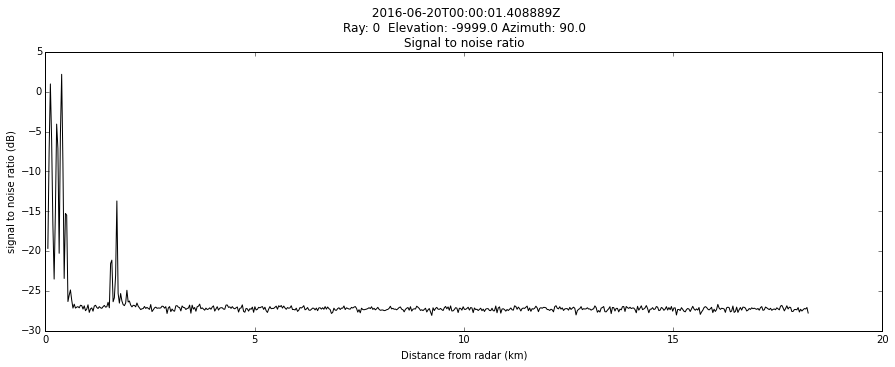

In [24]:
myfig = plt.figure(figsize = [15,5])
myd=pyart.graph.RadarDisplay(out_radar)
myd.plot_ray('daily_min_snr',0)

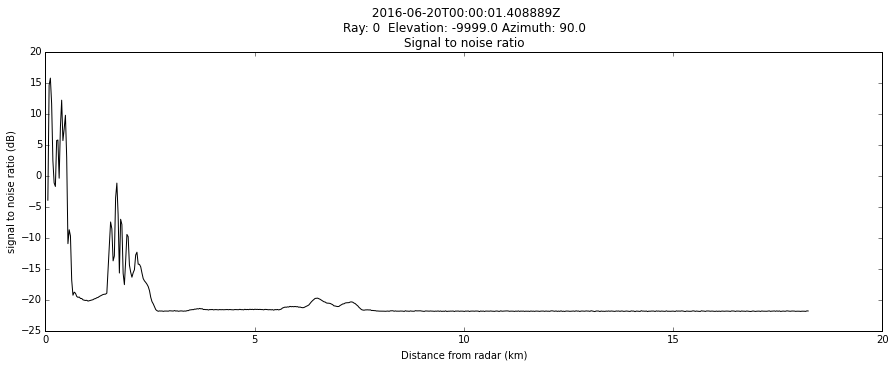

In [53]:
myfig = plt.figure(figsize = [15,5])
myd=pyart.graph.RadarDisplay(out_radar)
myd.plot_ray('daily_mean_sunny_snr',0)

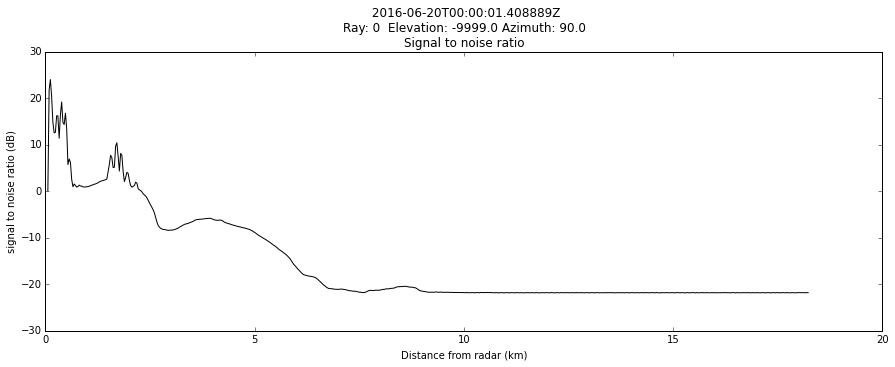

In [54]:
myfig = plt.figure(figsize = [15,5])
myd=pyart.graph.RadarDisplay(out_radar)
myd.plot_ray('daily_mean_snr',0)